# Instructions: 
1. For feature selections, run generate_train_test(*lag*, *weekly/monthly/daily*, *datasets used*) to generate training and testing dataset 
2. Uncomment .tocsv lines in the function to transform training and testing df to csv files.
3. Refer to last line of code for example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

In [2]:
# datasets chosen - tech companies
df_aapl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

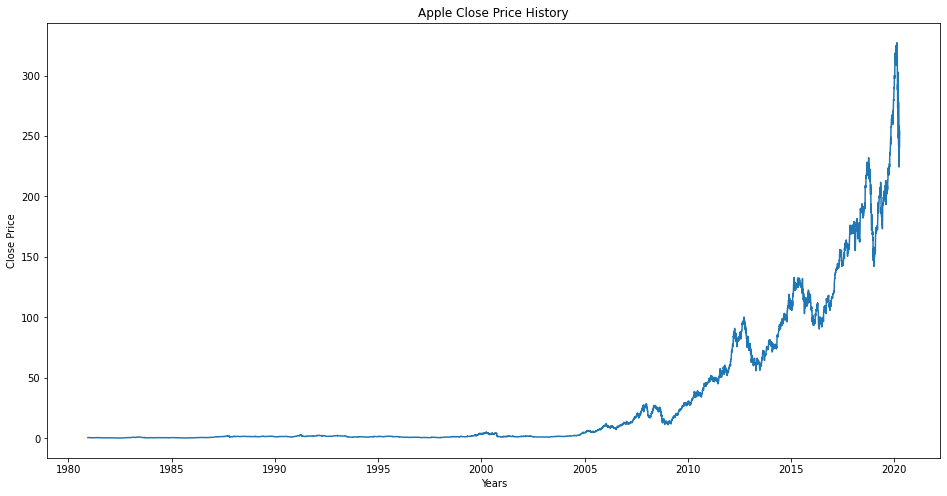

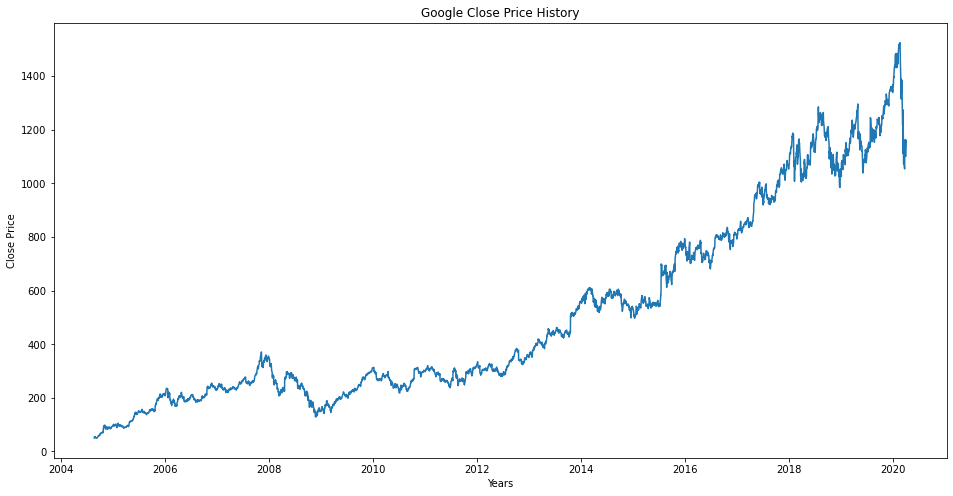

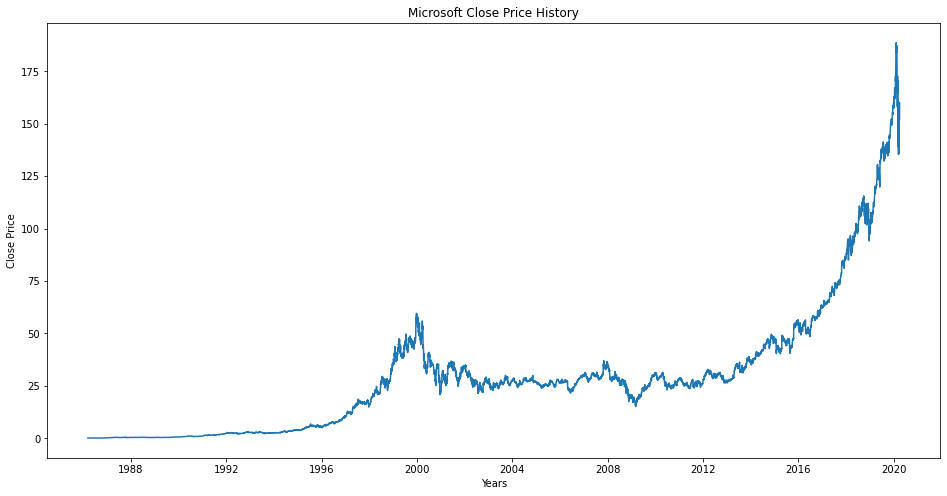

In [3]:
# apple
df_aapl['Date'] = pd.to_datetime(df_aapl.Date,format='%Y-%m-%d')
df_aapl.index = df_aapl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_aapl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [4]:
def split(df):
    train_size = round(len(df)*0.7)
    y_movement = df['movement']
    y_t = df['Close (t)']
    X_colnames = df.drop(['Close (t)', 'movement'], axis=1).columns
    X = df[X_colnames]

    # for movement
    X_train, X_test, y_train_movement, y_test_movement = X[:train_size], X[train_size:], y_movement[:train_size], y_movement[train_size:]

    # for t
    X_train, X_test, y_train_t, y_test_t = X[:train_size], X[train_size:], y_t[:train_size], y_t[train_size:]
    train_df = pd.concat([X_train,y_train_t,y_train_movement],axis = 1)
    test_df = pd.concat([X_test,y_test_t, y_test_movement],axis = 1)
    return train_df, test_df

In [5]:
def shift(df, n):
    new_df = pd.DataFrame()
    # volume
    vol = "Volume (t-"+str(n)+")"
    new_df[vol] = df['Volume']
    for i in range(n-1,0,-1):
        v = "Volume (t-"+str(i)+")"
        new_df[v] = df['Volume'].shift(-(n-i))

    # close price
    p = "Close (t-"+str(n)+")"
    new_df[p] = df['Close']
    for i in range(n-1,0,-1):
        v = "Close (t-"+str(i)+")"
        new_df[v] = df['Close'].shift(-(n-i))

    # y-variable (close price)
    new_df['Close (t)'] = df['Close'].shift(-n)
    new_df = new_df.dropna()

    # y-variable (movement)
    new_df['movement'] = np.where(new_df["Close (t)"] > new_df['Close (t-1)'], 1, 0)
    return new_df


In [6]:
# Automate pipeline to generate training and testing datasets based on lag
def generate_train_test(lag, avg = "weekly", *datasets):
    """
    Return the training and testing dataset, uncomment to transform df to csv after feature selections
    """
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for df in datasets:
        if avg == "weekly":
            df = df.resample('W').mean()
        elif avg == "monthly":
            df = df.resample('M').mean()
        #else, daily, noneed groupby
        df = shift(df, lag)
        train_df, test_df = split(df)
        train_all = pd.concat([train_all, train_df])
        test_all = pd.concat([test_all, test_df])
    #train_all.to_csv(str(lag)+"_"+avg+"_train.csv")
    #test_all.to_csv(str(lag)+"_"+avg+"_test.csv")
    return train_all, test_all


In [7]:
# Remove data where price stagnant
df_aapl = df_aapl[(df_aapl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

In [8]:

train_msft, test_msft = generate_train_test(10, "weekly", df_msft)
train_ggl, test_ggl = generate_train_test(10, "weekly", df_ggl)

## AAPL

### With 10 steps

In [9]:
train_aapl, test_aapl = generate_train_test(10, "weekly", df_aapl)
train_aapl.columns

Index(['Volume (t-10)', 'Volume (t-9)', 'Volume (t-8)', 'Volume (t-7)',
       'Volume (t-6)', 'Volume (t-5)', 'Volume (t-4)', 'Volume (t-3)',
       'Volume (t-2)', 'Volume (t-1)', 'Close (t-10)', 'Close (t-9)',
       'Close (t-8)', 'Close (t-7)', 'Close (t-6)', 'Close (t-5)',
       'Close (t-4)', 'Close (t-3)', 'Close (t-2)', 'Close (t-1)', 'Close (t)',
       'movement'],
      dtype='object')

** features should exclude 'movement' and 'Close (t)'

In [10]:
model_aapl = LinearRegression()
x_train_aapl = train_aapl.drop(['Close (t)', 'movement'], axis=1)
y_train_aapl = train_aapl['Close (t)']
model_aapl.fit(x_train_aapl, y_train_aapl)

LinearRegression()

In [11]:
x_test_aapl = test_aapl.drop(['Close (t)', 'movement'], axis=1)
y_test_aapl = test_aapl['Close (t)']

preds_aapl = model_aapl.predict(x_test_aapl)
rms_aapl = np.sqrt(np.mean(np.power((np.array(y_test_aapl)-np.array(preds_aapl)),2)))

In [12]:
rms_aapl

5.301346140074838

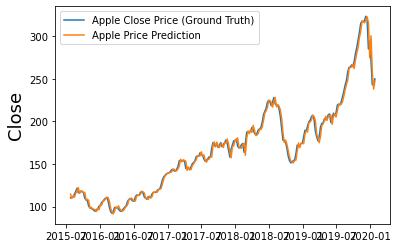

In [13]:
# plot
df_results = pd.DataFrame()
df_results['Apple Close Price (Ground Truth)'] = test_aapl['Close (t)']
df_results['Apple Price Prediction'] = preds_aapl

plt.plot(df_results['Apple Close Price (Ground Truth)'])
plt.plot(df_results['Apple Price Prediction'])

plt.ylabel('Close',fontsize=18)
plt.legend(['Apple Close Price (Ground Truth)','Apple Price Prediction'])
plt.show()

In [14]:
move_test_aapl = test_aapl['movement']

pred_move_aapl = (preds_aapl - test_aapl["Close (t-1)"]) 
pred_move_aapl = pred_move_aapl.where(pred_move_aapl<0, 1).where(pred_move_aapl>=0, 0).astype(int)

In [15]:
print("Apple")
print(confusion_matrix(move_test_aapl, pred_move_aapl))
print('Precision: %.3f' % precision_score(move_test_aapl, pred_move_aapl))
print('Recall: %.3f' % recall_score(move_test_aapl, pred_move_aapl))
print('Accuracy: %.3f' % accuracy_score(move_test_aapl, pred_move_aapl))
print('F1-score: %.3f\n' % f1_score(move_test_aapl, pred_move_aapl))

Apple
[[46 46]
 [50 94]]
Precision: 0.671
Recall: 0.653
Accuracy: 0.593
F1-score: 0.662



### With 13 steps (one quarter)

Index(['Volume (t-13)', 'Volume (t-12)', 'Volume (t-11)', 'Volume (t-10)',
       'Volume (t-9)', 'Volume (t-8)', 'Volume (t-7)', 'Volume (t-6)',
       'Volume (t-5)', 'Volume (t-4)', 'Volume (t-3)', 'Volume (t-2)',
       'Volume (t-1)', 'Close (t-13)', 'Close (t-12)', 'Close (t-11)',
       'Close (t-10)', 'Close (t-9)', 'Close (t-8)', 'Close (t-7)',
       'Close (t-6)', 'Close (t-5)', 'Close (t-4)', 'Close (t-3)',
       'Close (t-2)', 'Close (t-1)', 'Close (t)', 'movement'],
      dtype='object')
rms aapl: 5.341107495742939


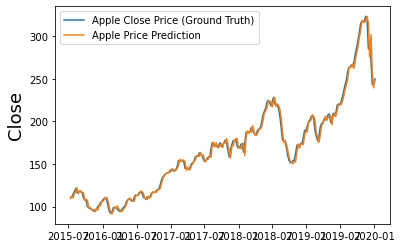

Apple
[[49 42]
 [54 90]]
Precision: 0.682
Recall: 0.625
Accuracy: 0.591
F1-score: 0.652



In [16]:
train_aapl, test_aapl = generate_train_test(13, "weekly", df_aapl)
print(train_aapl.columns)

model_aapl = LinearRegression()
x_train_aapl = train_aapl.drop(['Close (t)', 'movement'], axis=1)
y_train_aapl = train_aapl['Close (t)']
model_aapl.fit(x_train_aapl, y_train_aapl)

x_test_aapl = test_aapl.drop(['Close (t)', 'movement'], axis=1)
y_test_aapl = test_aapl['Close (t)']

preds_aapl = model_aapl.predict(x_test_aapl)
rms_aapl = np.sqrt(np.mean(np.power((np.array(y_test_aapl)-np.array(preds_aapl)),2)))

print('rms aapl:', rms_aapl)

# plot
df_results = pd.DataFrame()
df_results['Apple Close Price (Ground Truth)'] = test_aapl['Close (t)']
df_results['Apple Price Prediction'] = preds_aapl

plt.plot(df_results['Apple Close Price (Ground Truth)'])
plt.plot(df_results['Apple Price Prediction'])

plt.ylabel('Close',fontsize=18)
plt.legend(['Apple Close Price (Ground Truth)','Apple Price Prediction'])
plt.show()

move_test_aapl = test_aapl['movement']

pred_move_aapl = (preds_aapl - test_aapl["Close (t-1)"]) 
pred_move_aapl = pred_move_aapl.where(pred_move_aapl<0, 1).where(pred_move_aapl>=0, 0).astype(int)

print("Apple")
print(confusion_matrix(move_test_aapl, pred_move_aapl))
print('Precision: %.3f' % precision_score(move_test_aapl, pred_move_aapl))
print('Recall: %.3f' % recall_score(move_test_aapl, pred_move_aapl))
print('Accuracy: %.3f' % accuracy_score(move_test_aapl, pred_move_aapl))
print('F1-score: %.3f\n' % f1_score(move_test_aapl, pred_move_aapl))

In [ ]:
def linear_regression_clean(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, aggr_fun, df_stock)

    model_stock = LinearRegression()
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)

    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    # plot
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    return rms_stock, precision, recall, accuracy, f1_score
    

In [ ]:
rmss = []
precisions = []
recalls = []
accuracies = []
f1_scores = []

lag_range = [i for i in range(1, 32)]

for i in lag_range:
    rms_stock, precision, recall, accuracy, f1_score = linear_regression_clean(name='Apple', df_stock=df_aapl, lag=i)
    rmss.append(rms_stock)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

i = 0
performances_arr = np.transpose(np.array([rmss, precisions, recalls, accuracies, f1_scores]))
per_str = ['rmss', 'precisions', 'recalls', 'accuracies', 'f1_scores']
df_perform_aapl = pd.DataFrame(data=performances_arr, index=lag_range, columns=per_str)


In [ ]:
df_perform_aapl

In [ ]:
values = df_perform_aapl.values
groups = range(0,4)
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_perform_aapl.columns[group], y=0.5, loc='right')
    i += 1
plt.show()